In [1]:
!pip install influxdb_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.3/746.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 13.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

In [3]:
''' Creating the connection with the influx database '''

from influxdb_client import InfluxDBClient

# Define your InfluxDB connection parameters
url = "http://kammeyer.uk:8086"
token = "CPSJ6xw1U72IcJjfLgzaukP24o1CL3grIQuvaw-Zq1MK9htUYNPwFUdKEalwl2-xMHFrVKOgG8tRFLgIkoneBw=="
org = "591d9e9c3fc5e3ee"

# Create a client instance
client = InfluxDBClient(url=url, token=token, org=org)

In [4]:
'price data after pivoting the columns and values in the last 5 years'
import numpy as np

bucket = 'price'
# Example of querying data
query = '''from(bucket:"''' + bucket + '''")
          |> range(start: -10y, stop: 2025-06-15T00:00:00Z)
          |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
          |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'''
query_result = client.query_api().query_data_frame(query)

data = query_result[['_time', 'Deutchland/Luxembourg']].copy()

In [5]:
print(data)
print(data.shape)

                          _time  Deutchland/Luxembourg
0     2018-09-30 23:00:00+00:00                  59.53
1     2018-10-01 00:00:00+00:00                  56.10
2     2018-10-01 01:00:00+00:00                  51.41
3     2018-10-01 02:00:00+00:00                  47.38
4     2018-10-01 03:00:00+00:00                  47.59
...                         ...                    ...
58773 2025-06-14 20:00:00+00:00                 117.68
58774 2025-06-14 21:00:00+00:00                 121.39
58775 2025-06-14 22:00:00+00:00                 109.00
58776 2025-06-14 23:00:00+00:00                  91.93
58777 2025-06-15 00:00:00+00:00                  88.87

[58778 rows x 2 columns]
(58778, 2)


In [6]:
#engineering time based features

data['_time'] = pd.to_datetime(data['_time'])
data['hour'] = data['_time'].dt.hour
data['day'] = data['_time'].dt.day
data['month'] = data['_time'].dt.month
data['day_of_week'] = data['_time'].dt.dayofweek
data['day_of_year'] = data['_time'].dt.dayofyear

# Hour of Day (0-23, max_value=24)
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Day of Week (0-6, max_value=7)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Month of Year (1-12, max_value=12)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Day of Year (1-365.25, max_value=365.25)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365.25)
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365.25)

In [7]:
#engineering lagged features based on target

data['lagged_1h'] = data['Deutchland/Luxembourg'].shift(1) #1 hour
data['lagged_2h'] = data['Deutchland/Luxembourg'].shift(2) #2 hours
data['lagged_3h'] = data['Deutchland/Luxembourg'].shift(3) #3 hours
data['lagged_4h'] = data['Deutchland/Luxembourg'].shift(4) #4 hours
data['lagged_10h'] = data['Deutchland/Luxembourg'].shift(10) #10 hours
data['lagged_11h'] = data['Deutchland/Luxembourg'].shift(11) #11 hours
data['lagged_12h'] = data['Deutchland/Luxembourg'].shift(12) #12 hours
data['lagged_13h'] = data['Deutchland/Luxembourg'].shift(13) #13 hours
data['lagged_22h'] = data['Deutchland/Luxembourg'].shift(22) #22 hours
data['lagged_23h'] = data['Deutchland/Luxembourg'].shift(23) #23 hours
data['lagged_24h'] = data['Deutchland/Luxembourg'].shift(24) #24 hours = 1 day
data['lagged_25h'] = data['Deutchland/Luxembourg'].shift(25) #25 hours
data['lagged_48h'] = data['Deutchland/Luxembourg'].shift(48) #48 hours = 2 days
data['lagged_168h'] = data['Deutchland/Luxembourg'].shift(168) # 168 hours = 7 days

In [8]:
#adding rolling means
data['rolling_mean_1h'] = data['Deutchland/Luxembourg'].shift(1).rolling(1).mean()
data['rolling_mean_2h'] = data['Deutchland/Luxembourg'].shift(1).rolling(2).mean()
data['rolling_mean_3h'] = data['Deutchland/Luxembourg'].shift(1).rolling(3).mean()
data['rolling_mean_6h'] = data['Deutchland/Luxembourg'].shift(1).rolling(6).mean()
data['rolling_mean_12h'] = data['Deutchland/Luxembourg'].shift(1).rolling(12).mean()
data['rolling_mean_24h'] = data['Deutchland/Luxembourg'].shift(1).rolling(24).mean()
data['rolling_mean_48h'] = data['Deutchland/Luxembourg'].shift(1).rolling(48).mean()
data['rolling_mean_168h'] = data['Deutchland/Luxembourg'].shift(1).rolling(168).mean()

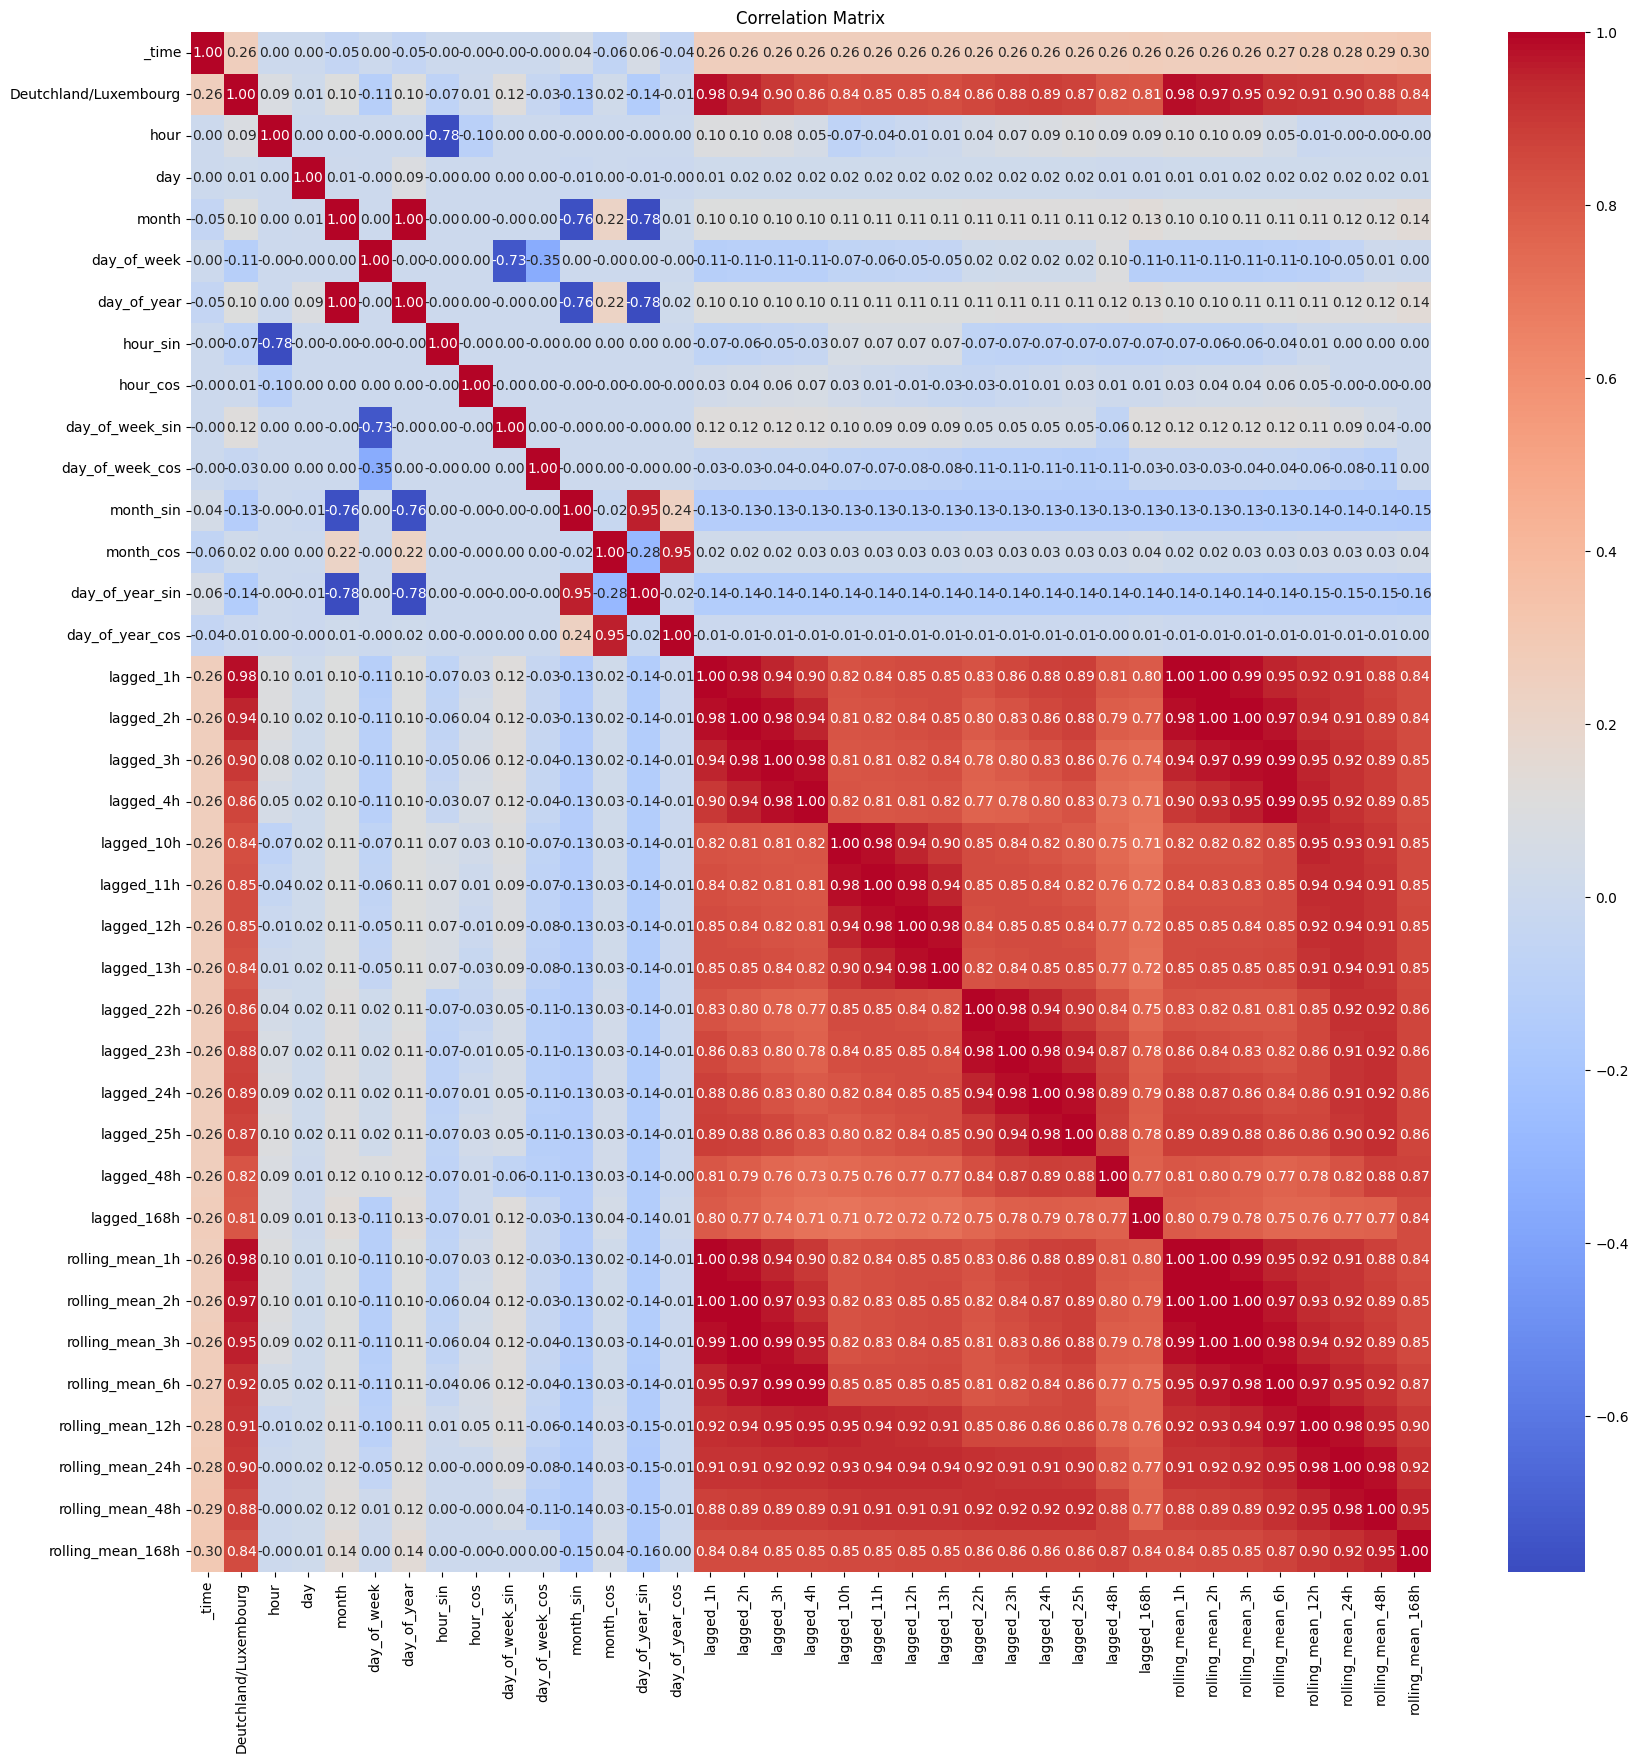

In [9]:
# Creating the Correlation Table

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [10]:
#checking for null values in each column
print(data.isna().sum())

_time                      0
Deutchland/Luxembourg      0
hour                       0
day                        0
month                      0
day_of_week                0
day_of_year                0
hour_sin                   0
hour_cos                   0
day_of_week_sin            0
day_of_week_cos            0
month_sin                  0
month_cos                  0
day_of_year_sin            0
day_of_year_cos            0
lagged_1h                  1
lagged_2h                  2
lagged_3h                  3
lagged_4h                  4
lagged_10h                10
lagged_11h                11
lagged_12h                12
lagged_13h                13
lagged_22h                22
lagged_23h                23
lagged_24h                24
lagged_25h                25
lagged_48h                48
lagged_168h              168
rolling_mean_1h            1
rolling_mean_2h            2
rolling_mean_3h            3
rolling_mean_6h            6
rolling_mean_12h          12
rolling_mean_2

In [11]:
data.dropna(inplace=True)

In [12]:
X = data.drop(['_time', 'hour', 'day', 'month', 'day_of_week', 'day_of_year', 'Deutchland/Luxembourg'], axis=1)
y = data['Deutchland/Luxembourg']

print(X.shape)
print(y.shape)

(58610, 30)
(58610,)


In [13]:
def create_lstm_training_sequences(data, target, input_steps=48, forecast_horizon=1):
    """
    Prepare sequences for LSTM training.

    Parameters:
        data (pd.DataFrame): Historical data containing lagged features, temproal features, and rolling means.
        target_col (str): Column name to predict (e.g., 'Price').
        input_steps (int): Number of past hours to use as input sequence length.
        forecast_horizon (int): Number of future hours to predict.

    Returns:
        X (np.ndarray): Input sequences of shape (samples, input_steps, num_features).
        y (np.ndarray): Target sequences of shape (samples, forecast_horizon).
    """
    X, y = [], []

    # Loop to create sequences within the historical data length
    max_start_idx = len(data) - input_steps - forecast_horizon + 1

    for i in range(max_start_idx):
        # Input: past `input_steps` hours of features
        X_seq = data.iloc[i : i + input_steps].values

        # Target: next `forecast_horizon` hours of price (known historical values)
        y_seq = target.iloc[i + input_steps : i + input_steps + forecast_horizon].values

        X.append(X_seq)
        y.append(y_seq)

    return np.array(X), np.array(y)

In [14]:
# Prepare sequences for LSTM training
X_seq, y_targets = create_lstm_training_sequences(X, y, input_steps=48, forecast_horizon=1)

print("X seq shape:", X_seq.shape)  # (samples, 48, features)
print("y targets shape:", y_targets.shape)  # (samples, 1)

X seq shape: (58562, 48, 30)
y targets shape: (58562, 1)


In [15]:
# Define the split ratio
train_ratio = 0.9  # 90% for training, 10% for testing

# Calculate the index to split the data
# Ensure 'X_sequences' is defined from your actual data
split_index = int(len(X_seq) * train_ratio)

# Split the data chronologically
X_train = X_seq[:split_index]
y_train = y_targets[:split_index]

X_test = X_seq[split_index:]
y_test = y_targets[split_index:]

print(f"Training set size (X_train): {X_train.shape}")
print(f"Testing set size (X_test): {X_test.shape}")
print(f"Training target size (y_train): {y_train.shape}")
print(f"Testing target size (y_test): {y_test.shape}")

Training set size (X_train): (52705, 48, 30)
Testing set size (X_test): (5857, 48, 30)
Training target size (y_train): (52705, 1)
Testing target size (y_test): (5857, 1)


In [16]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

# Reshape X_train from 3D to 2D (samples * timesteps, features) for fitting
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1]) # Combines samples and timesteps dimensions
X_scaler.fit(X_train_reshaped)

# Transform both training and testing X data
X_train_scaled = X_scaler.transform(X_train_reshaped).reshape(X_train.shape) # Transform and reshape back to 3D
X_test_scaled = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# Scaler for y (target values)
# y_train is already 2D (num_samples, forecast_horizon), so no complex reshaping needed
y_scaler = MinMaxScaler()

# Fit the y_scaler ONLY on the training target data
y_scaler.fit(y_train)

# Transform both training and testing y data
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test) # Transform y_test using scaler fitted on y_train


print("\n--- After Scaling ---")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")


--- After Scaling ---
X_train_scaled shape: (52705, 48, 30)
X_test_scaled shape: (5857, 48, 30)
y_train_scaled shape: (52705, 1)
y_test_scaled shape: (5857, 1)


In [17]:
!pip install tensorflow

In [18]:
import tensorflow as tf

# Corrected import for register_keras_serializable
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable() # Use the imported decorator directly
class TwoSidedAsymmetricHuberLoss(tf.keras.losses.Loss):
    """
    A custom two-sided asymmetric Huber loss function with value-dependent penalties.

    This loss penalizes:
    - Underpredictions (y_pred < y_true) more, especially when y_true is high (spikes).
    - Overpredictions (y_pred > y_true) more, especially when y_true is low (troughs/negative prices).
    """
    def __init__(self,
                 delta,
                 base_under_penalty_factor,
                 peak_penalty_scalar,
                 base_over_penalty_factor,
                 trough_penalty_scalar,
                 name="TwoSidedAsymmetricHuberLoss",
                 **kwargs):
        super().__init__(name=name)
        # Store all hyperparameters as attributes of the class
        self.delta = delta
        self.base_under_penalty_factor = base_under_penalty_factor
        self.peak_penalty_scalar = peak_penalty_scalar
        self.base_over_penalty_factor = base_over_penalty_factor
        self.trough_penalty_scalar = trough_penalty_scalar

    # This method defines the forward pass (how the loss is calculated)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.math.abs(error)

        # Huber loss core
        quadratic_part = 0.5 * tf.math.square(error)
        linear_part = self.delta * abs_error - 0.5 * tf.math.square(self.delta)
        huber_loss_per_sample = tf.where(abs_error <= self.delta, quadratic_part, linear_part)

        # Masks for underpredictions and overpredictions
        # error > 0 means y_true > y_pred (underprediction)
        underprediction_mask = tf.cast(tf.math.greater(error, 0), tf.float32)
        # error <= 0 means y_true <= y_pred (overprediction or exact prediction)
        overprediction_mask = tf.cast(tf.math.less_equal(error, 0), tf.float32)

        # Dynamic penalty for UNDERPREDICTIONS (missing high spikes)
        # Penalty increases as y_true (normalized price) gets higher
        dynamic_under_penalty = self.base_under_penalty_factor + (y_true * self.peak_penalty_scalar)

        # Dynamic penalty for OVERPREDICTIONS (missing low spikes/troughs)
        # Penalty increases as y_true (normalized price) gets LOWER.
        # (1.0 - y_true) is large when y_true is small (near 0) and small when y_true is large (near 1).
        dynamic_over_penalty = self.base_over_penalty_factor + ((1.0 - y_true) * self.trough_penalty_scalar)

        # Apply the dynamic asymmetric weighting
        asymmetric_loss = (underprediction_mask * dynamic_under_penalty * huber_loss_per_sample) + \
                          (overprediction_mask * dynamic_over_penalty * huber_loss_per_sample)

        # Return the mean loss across the batch
        return tf.reduce_mean(asymmetric_loss)

    # This method is crucial for serialization: it tells Keras how to reconstruct the object
    # when loading a saved model. It should return a dictionary containing the arguments
    # needed to re-instantiate the class.
    def get_config(self):
        config = super().get_config() # Get the base config from the parent class
        config.update({
            "delta": self.delta,
            "base_under_penalty_factor": self.base_under_penalty_factor,
            "peak_penalty_scalar": self.peak_penalty_scalar,
            "base_over_penalty_factor": self.base_over_penalty_factor,
            "trough_penalty_scalar": self.trough_penalty_scalar,
        })
        return config

delta = 0.01 # Huber transition point (tune around normalized MAE)
base_under_penalty_factor = 1.0 # Minimum multiplier for underpredictions
peak_penalty_scalar = 5.0       # Higher values mean stronger penalty for missing HIGH peaks

# For overpredicting low spikes/troughs:
base_over_penalty_factor = 1.3  # Minimum multiplier for overpredictions
trough_penalty_scalar = 4.5      # Higher values mean stronger penalty for overpredicting LOW troughs

# 2. Create an instance of custom loss function using the factory
# This call returns the '_loss_fn' function itself.
custom_loss_callable = TwoSidedAsymmetricHuberLoss(
    delta=delta,
    base_under_penalty_factor=base_under_penalty_factor,
    peak_penalty_scalar=peak_penalty_scalar,
    base_over_penalty_factor=base_over_penalty_factor,
    trough_penalty_scalar=trough_penalty_scalar
)

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, BatchNormalization
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(64, 2, activation='relu', padding='same', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='valid'))
model.add(Conv1D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='valid'))
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output layer predicts 1 hour ahead

model.compile(optimizer='adam', loss=custom_loss_callable, metrics=['mae', 'mse'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,609 (330.50 KB)

 Trainable params: 84,225 (329.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [20]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',   # watch validation loss
    patience=15,          # wait 15 epochs before stopping
    restore_best_weights=True  # restore model weights from the best epoch
)

In [21]:
from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce LR by 50%
    patience=10,         # Wait for 10 epochs without improvement
    min_lr=1e-7,         # Don't go below this LR
    verbose=1            # Print updates when LR changes
)

In [22]:
callbacks_list = [
    early_stop,
    lr_scheduler
]

In [23]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=callbacks_list
)

Epoch 1/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - loss: 0.0013 - mae: 0.0405 - mse: 0.0053 - val_loss: 4.5315e-04 - val_mae: 0.0166 - val_mse: 6.7645e-04 - learning_rate: 0.0010
Epoch 2/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 79s 52ms/step - loss: 3.6782e-04 - mae: 0.0145 - mse: 4.4955e-04 - val_loss: 5.1635e-04 - val_mae: 0.0198 - val_mse: 7.6429e-04 - learning_rate: 0.0010
Epoch 3/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - loss: 2.6607e-04 - mae: 0.0114 - mse: 2.9618e-04 - val_loss: 3.3184e-04 - val_mae: 0.0131 - val_mse: 4.9393e-04 - learning_rate: 0.0010
Epoch 4/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - loss: 2.4181e-04 - mae: 0.0105 - mse: 2.6612e-04 - val_loss: 2.6796e-04 - val_mae: 0.0108 - val_mse: 4.0467e-04 - learning_rate: 0.0010
Epoch 5/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - loss: 2.1326e-04 - mae: 0.0096 - mse: 2.2702e-04 - val_loss: 4.6213e-04 - val_mae: 0.0163 - val_mse: 5.5828e-04 - learning_rate: 0.0010
Epoch 6/200
824/824 ━━━━━━━━━━━━━━━━━━━━ 79

In [25]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/'
%cd 'Time_Series_V28/'

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/Time_Series_V28


In [26]:
model.save("lstm_price_forecasting_univariate_v28.keras")

In [27]:
import joblib
joblib.dump(X_scaler, 'univariate_minmax_X_scaler_v28.gz')
joblib.dump(y_scaler, 'univariate_minmax_Y_scaler_v28.gz')

['univariate_minmax_Y_scaler_v28.gz']

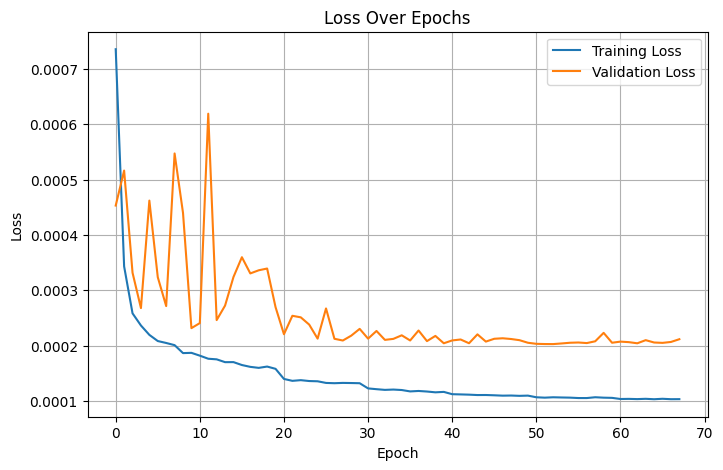

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
predictions = model.predict(X_test_scaled)
predictions

184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


array([[0.38257006],
       [0.38786384],
       [0.3892784 ],
       ...,
       [0.4322254 ],
       [0.43321112],
       [0.43574518]], dtype=float32)

In [30]:
actual = y_scaler.inverse_transform(y_test_scaled)
predictions = y_scaler.inverse_transform(predictions)

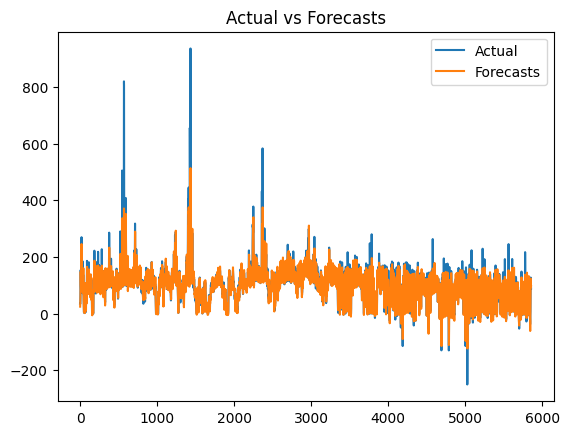

In [31]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Forecasts')
plt.legend()
plt.title("Actual vs Forecasts")
plt.show()